In [17]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import utils
from sklearn.utils import shuffle
import tensorflow as tf

import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [18]:
ts=pd.read_csv("/Users/david/Desktop/DM2 project/fma_metadata/ts_centroid.csv")
ts.shape

(1028, 1209)

In [19]:
tracks= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/tracks.csv")
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks=tracks.droplevel(0,axis=1)
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [20]:
ts_df=pd.merge(tracks,ts, on='track_id')
ts_df.head()

,track_id,split,subset,genre_top,Unnamed: 0,Unnamed: 0.1,0,1,2,3,...,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205
0,4850,validation,medium,Classical,13,206,0.203188,0.177222,0.170356,0.174893,...,0.429477,0.438678,0.423448,0.416010,0.414990,0.434620,0.557168,0.779985,0.852099,0.806474
1,4851,validation,medium,Classical,14,207,0.139737,0.162770,0.188715,0.196280,...,0.100511,0.092096,0.077473,0.062344,0.058620,0.039428,0.035532,0.036547,0.003289,0.039476
2,5009,training,medium,Old-Time / Historic,15,208,0.097878,0.141881,0.181742,0.295769,...,0.396982,0.354043,0.370011,0.368628,0.309365,0.282796,0.272292,0.276301,0.301752,0.270572
3,5012,training,medium,Old-Time / Historic,16,209,0.088058,0.103542,0.167626,0.233723,...,0.291008,0.467978,0.473676,0.195546,0.092509,0.263610,0.330493,0.367824,0.399824,0.282295
4,5013,training,medium,Old-Time / Historic,17,210,0.134297,0.198303,0.286986,0.377489,...,0.469473,0.409380,0.320596,0.243092,0.350757,0.478701,0.517602,0.362054,0.187761,0.319275


In [21]:
ts_df.drop(index=ts_df[ts_df.subset=='large'].index, inplace=True)
train = ts_df.index[ts_df['split'] == 'training']
val = ts_df.index[ts_df['split'] == 'validation']
test = ts_df.index[ts_df['split'] == 'test']

In [22]:
ts_df['genre_top'].unique()

['Classical', 'Old-Time / Historic']
Categories (2, object): ['Classical', 'Old-Time / Historic']

In [23]:
ts_df['genre_top'].value_counts()

Classical              526
Old-Time / Historic    502
Blues                    0
Country                  0
Easy Listening           0
Electronic               0
Experimental             0
Folk                     0
Hip-Hop                  0
Instrumental             0
International            0
Jazz                     0
Pop                      0
Rock                     0
Soul-RnB                 0
Spoken                   0
Name: genre_top, dtype: int64

In [24]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
#function for encoding categorical variables
le=LabelBinarizer()
#le=LabelEncoder()
ts_df['genre_top']=le.fit_transform(ts_df['genre_top'])
ts_df.head()

,track_id,split,subset,genre_top,Unnamed: 0,Unnamed: 0.1,0,1,2,3,...,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205
0,4850,validation,medium,0,13,206,0.203188,0.177222,0.170356,0.174893,...,0.429477,0.438678,0.423448,0.416010,0.414990,0.434620,0.557168,0.779985,0.852099,0.806474
1,4851,validation,medium,0,14,207,0.139737,0.162770,0.188715,0.196280,...,0.100511,0.092096,0.077473,0.062344,0.058620,0.039428,0.035532,0.036547,0.003289,0.039476
2,5009,training,medium,1,15,208,0.097878,0.141881,0.181742,0.295769,...,0.396982,0.354043,0.370011,0.368628,0.309365,0.282796,0.272292,0.276301,0.301752,0.270572
3,5012,training,medium,1,16,209,0.088058,0.103542,0.167626,0.233723,...,0.291008,0.467978,0.473676,0.195546,0.092509,0.263610,0.330493,0.367824,0.399824,0.282295
4,5013,training,medium,1,17,210,0.134297,0.198303,0.286986,0.377489,...,0.469473,0.409380,0.320596,0.243092,0.350757,0.478701,0.517602,0.362054,0.187761,0.319275


In [25]:
ts_df['genre_top'].unique()

array([0, 1])

In [26]:
ts_df['genre_top'].value_counts()

0    526
1    502
Name: genre_top, dtype: int64

In [27]:
y=ts_df['genre_top']

In [28]:
y_train = ts_df['genre_top'].loc[ts_df['split'] == 'training']
y_val = ts_df['genre_top'].loc[ts_df['split'] == 'validation']
y_test = ts_df['genre_top'].loc[ts_df['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((807,), (109,), (112,))

In [29]:
X=ts_df.drop('genre_top',axis=1)

In [30]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']

X_train.shape, X_val.shape, X_test.shape

((807, 1211), (109, 1211), (112, 1211))

In [31]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [32]:
cut_columns=['track_id','split','subset','Unnamed: 0','Unnamed: 0.1']#'genres_all'
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

In [33]:
# Rescale time series
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])
X_val= scaler.fit_transform(X_val).reshape(X_val.shape[0], X_val.shape[1])
X_test= scaler.fit_transform(X_test).reshape(X_test.shape[0], X_test.shape[1])

In [34]:
X_train

array([[1.00000000e+00, 5.97419989e-05, 5.62601961e-05, ...,
        3.56172494e-05, 3.51181623e-05, 3.30320013e-05],
       [1.00000000e+00, 4.39952323e-04, 3.92932394e-04, ...,
        4.14701940e-04, 5.31263435e-04, 5.54288227e-04],
       [1.00000000e+00, 8.12227096e-04, 7.93672237e-04, ...,
        2.91979300e-04, 3.08518981e-04, 4.11363636e-04],
       ...,
       [1.00000000e+00, 2.65555544e-04, 3.00280301e-04, ...,
        6.18869030e-04, 6.43665542e-04, 5.14342295e-04],
       [1.00000000e+00, 1.17026170e-04, 1.29705471e-04, ...,
        1.14047866e-04, 1.16744999e-04, 9.28026118e-05],
       [1.00000000e+00, 1.35211305e-04, 1.87089782e-04, ...,
        1.04055445e-03, 9.33569614e-04, 5.72232162e-04]])

# Shapelet Discovery

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score 
from tslearn.shapelets import ShapeletModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [37]:
n_ts, ts_sz = X_train.shape
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=2)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 807
ts_sz 1207
n_classes 2
shapelet_sizes {120: 5, 240: 5}


In [38]:
#help(ShapeletModel)

In [40]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer='sgd',
                        weight_regularizer=0.01,
                        max_iter=200,
                        verbose=1,
                       scale=True,
                       random_state=0)
#'sgd''Adam','RMSprop','Adamax','Adagrad','Adedelta'

In [41]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
4/4 [==============================] - 2s 469ms/step - loss: 0.7098 - binary_accuracy: 0.4870 - binary_crossentropy: 0.6931
Epoch 2/200
4/4 [==============================] - 3s 632ms/step - loss: 0.7098 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6931
Epoch 3/200
4/4 [==============================] - 2s 454ms/step - loss: 0.7098 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6932
Epoch 4/200
4/4 [==============================] - 2s 551ms/step - loss: 0.7098 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6931
Epoch 5/200
4/4 [==============================] - 2s 421ms/step - loss: 0.7097 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6931
Epoch 6/200
4/4 [==============================] - 2s 422ms/step - loss: 0.7097 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6931
Epoch 7/200
4/4 [==============================] - 2s 428ms/step - loss: 0.7097 - binary_accuracy: 0.5043 - binary_crossentropy: 0.6931
Epoch 8/200
4/4 [==============================]

KeyboardInterrupt: 

In [ ]:
y_pred = shp_clf.predict(X_test)

In [ ]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
predicted_labels = shp_clf.predict(X_train)
print("Correct classification rate:", accuracy_score(y_train, predicted_labels))

In [ ]:
predicted_locations = shp_clf.locate(X_train)

In [ ]:
ts_id = 1
plt.figure(figsize=(20,10))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))


plt.plot(X_train[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
    

## Shapelet Discovery Undersampling

In [78]:
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler

### Random Undersampling

In [79]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_paa, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 400, 1: 400})


Epoch 1/200
4/4 [==============================] - 0s 16ms/step - loss: 0.8174 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6931
Epoch 2/200
4/4 [==============================] - 0s 20ms/step - loss: 0.8156 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6931
Epoch 3/200
4/4 [==============================] - 0s 20ms/step - loss: 0.8138 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 4/200
4/4 [==============================] - 0s 22ms/step - loss: 0.8121 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 0.8103 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.8086 - binary_accuracy: 0.5025 - binary_crossentropy: 0.6931
Epoch 7/200
4/4 [==============================] - 0s 23ms/step - loss: 0.8069 - binary_accuracy: 0.5088 - binary_crossentropy: 0.6930
Epoch 8/200
4/4 [==============================] - 0s 2

4/4 [==============================] - 0s 19ms/step - loss: 0.7101 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6927
Epoch 122/200
4/4 [==============================] - 0s 19ms/step - loss: 0.7098 - binary_accuracy: 0.5663 - binary_crossentropy: 0.6927
Epoch 123/200
4/4 [==============================] - 0s 19ms/step - loss: 0.7095 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6927
Epoch 124/200
4/4 [==============================] - 0s 20ms/step - loss: 0.7092 - binary_accuracy: 0.5650 - binary_crossentropy: 0.6927
Epoch 125/200
4/4 [==============================] - 0s 20ms/step - loss: 0.7089 - binary_accuracy: 0.5638 - binary_crossentropy: 0.6927
Epoch 126/200
4/4 [==============================] - 0s 19ms/step - loss: 0.7086 - binary_accuracy: 0.5638 - binary_crossentropy: 0.6927
Epoch 127/200
4/4 [==============================] - 0s 21ms/step - loss: 0.7083 - binary_accuracy: 0.5562 - binary_crossentropy: 0.6927
Epoch 128/200
4/4 [==============================] - 0s

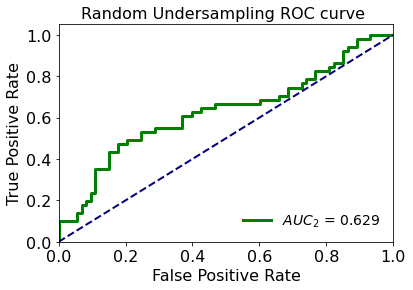

In [81]:
shp_clf.fit(X_res, y_res)

y_pred = shp_clf.predict(X_paa_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

y_score = shp_clf.predict_proba(X_paa_test)
fpr2, tpr2, _ = roc_curve(y_test, y_score[:, 1])
roc_auc2 = auc(fpr2, tpr2)

#plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=3, label='$AUC$ = %.3f' % (roc_auc_dt))
plt.plot(fpr2, tpr2, color='green', lw=3, label='$AUC_2$ = %.3f' % (roc_auc2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Random Undersampling ROC curve ', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [82]:
predicted_labels = shp_clf.predict(X_res)
print("Correct classification rate:", accuracy_score(y_res, predicted_labels))

4/4 [==============================] - 0s 13ms/step
Correct classification rate: 0.51125


In [83]:
predicted_locations = shp_clf.locate(X_res)

4/4 [==============================] - 0s 9ms/step


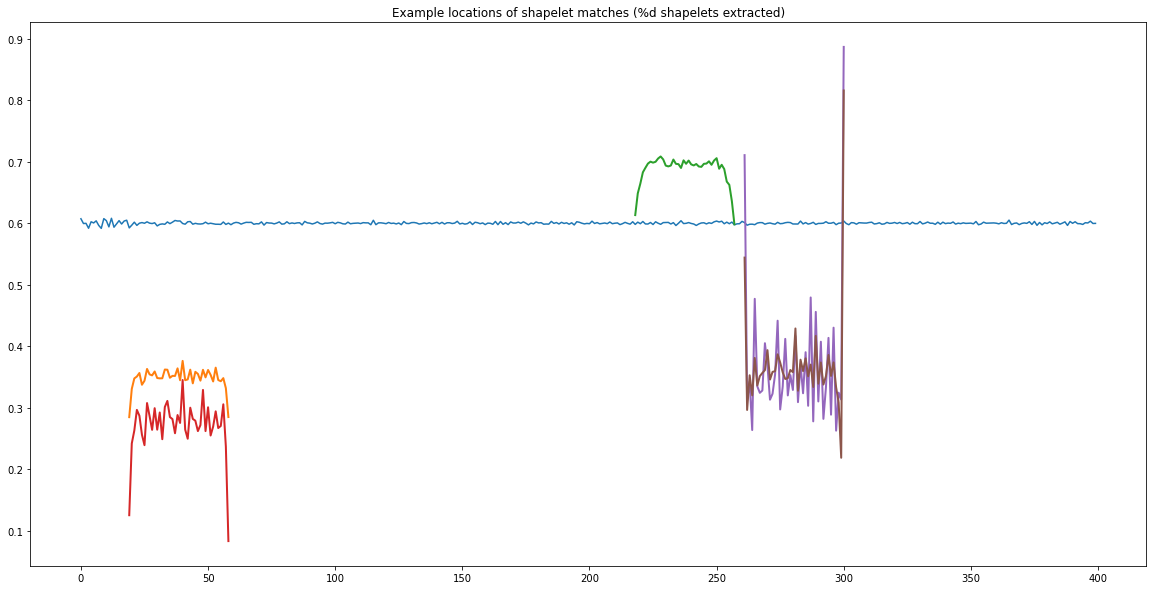

In [84]:
ts_id = 1
plt.figure(figsize=(20,10))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X_res[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

## Shapelet Discovery: Oversampling

In [85]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### Random Oversampling

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_paa, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Epoch 1/200
4/4 [==============================] - 0s 19ms/step - loss: 0.8174 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6931
Epoch 2/200
4/4 [==============================] - 0s 21ms/step - loss: 0.8156 - binary_accuracy: 0.5000 - binary_crossentropy: 0.6931
Epoch 3/200
4/4 [==============================] - 0s 24ms/step - loss: 0.8138 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 4/200
4/4 [==============================] - 0s 22ms/step - loss: 0.8121 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 5/200
4/4 [==============================] - 0s 25ms/step - loss: 0.8103 - binary_accuracy: 0.5013 - binary_crossentropy: 0.6931
Epoch 6/200
4/4 [==============================] - 0s 24ms/step - loss: 0.8086 - binary_accuracy: 0.5025 - binary_crossentropy: 0.6931
Epoch 7/200
4/4 [==============================] - 0s 22ms/step - loss: 0.8069 - binary_accuracy: 0.5088 - binary_crossentropy: 0.6930
Epoch 8/200
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 17ms/step - loss: 0.7101 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6927
Epoch 122/200
4/4 [==============================] - 0s 19ms/step - loss: 0.7098 - binary_accuracy: 0.5663 - binary_crossentropy: 0.6927
Epoch 123/200
4/4 [==============================] - 0s 20ms/step - loss: 0.7095 - binary_accuracy: 0.5625 - binary_crossentropy: 0.6927
Epoch 124/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7092 - binary_accuracy: 0.5650 - binary_crossentropy: 0.6927
Epoch 125/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7089 - binary_accuracy: 0.5638 - binary_crossentropy: 0.6927
Epoch 126/200
4/4 [==============================] - 0s 16ms/step - loss: 0.7086 - binary_accuracy: 0.5638 - binary_crossentropy: 0.6927
Epoch 127/200
4/4 [==============================] - 0s 18ms/step - loss: 0.7083 - binary_accuracy: 0.5562 - binary_crossentropy: 0.6927
Epoch 128/200
4/4 [==============================] - 0s

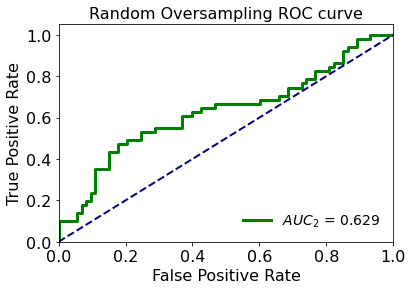

In [88]:
shp_clf.fit(X_res, y_res)

y_pred = shp_clf.predict(X_paa_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

y_score = shp_clf.predict_proba(X_paa_test)
fpr2, tpr2, _ = roc_curve(y_test, y_score[:, 1])
roc_auc2 = auc(fpr2, tpr2)

#plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=3, label='$AUC$ = %.3f' % (roc_auc_dt))
plt.plot(fpr2, tpr2, color='green', lw=3, label='$AUC_2$ = %.3f' % (roc_auc2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Random Oversampling ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [89]:
predicted_labels = shp_clf.predict(X_res)
print("Correct classification rate:", accuracy_score(y_res, predicted_labels))

4/4 [==============================] - 0s 16ms/step
Correct classification rate: 0.51125


In [90]:
predicted_locations = shp_clf.locate(X_res)

4/4 [==============================] - 0s 14ms/step


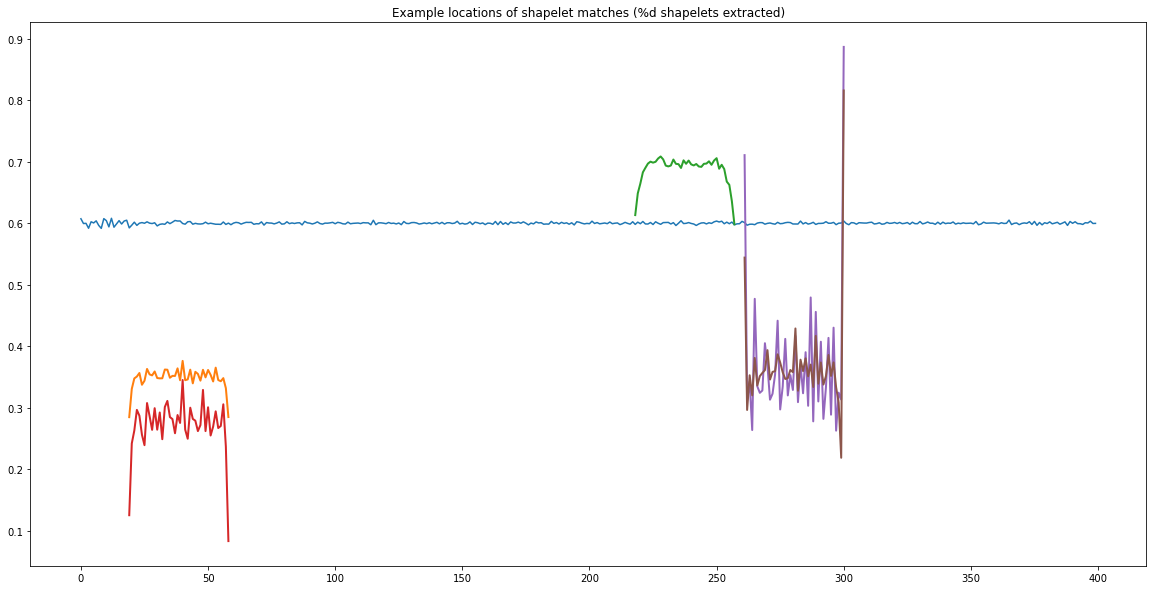

In [91]:
ts_id = 1
n_shapelets = sum(shapelet_sizes.values())
plt.figure(figsize=(20,10))
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X_res[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)